# *Одномерная модель на LSTM* (1 слой)

В качестве единственного признака используется сама цена.

In [1]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from pandas_datareader import data as pdr

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Flatten, ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

In [7]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [8]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [9]:
INSTRUMENT = 'CVX' # Chevron corp
START_FROM = '2008-11-14'
END_DATE = '2020-01-01'
WINDOW_SIZE = 60
FORECAST_OFFSET=1
BATCH_SIZE = 16
VAL_SPLIT = '2019-01-01'
TEST_SPLIT = '2019-06-01'
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [10]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM, end=END_DATE)

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

## Целевая переменная

Цена закрытия.

In [12]:
orig_target = instr.c

In [13]:
def plot_transformed_series(instrument, series, orig_display_name, transformed_display_name):
    plotHelpers.plot_transformed_timeseries(
        instrument.instrument,
        series,
        title_orig = orig_display_name,
        xlabel_orig = 'Date',
        ylabel_orig = orig_display_name,
        title_transformed = transformed_display_name,
        xlabel_transformed = 'Date',
        ylabel_transformed = transformed_display_name
    )

Переходим к логарифмической доходности.

In [14]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

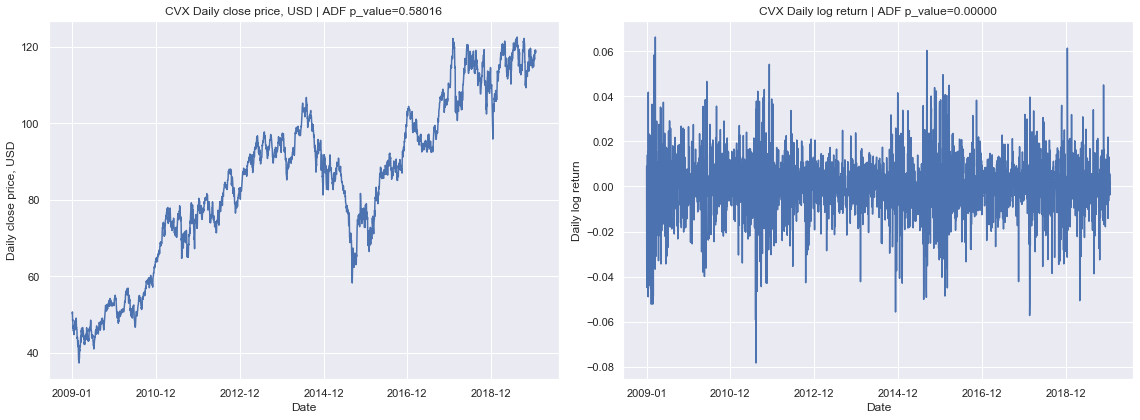

In [15]:
plot_transformed_series(instr,
                        transformed_target,
                        'Daily close price, USD', 'Daily log return')

## Трансформация признаков

Выбираем только один признак: цену закрытия.
Временной ряд цены преобразуется к логарифмической доходности (что также позволяет убрать нестационарность).

In [16]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [17]:
instr_transformed = instr.select_transform(make_feature_selector())

In [18]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [19]:
instr_train, instr_val_test = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                 scaler=StandardScaler)
#                                                                  scaler=MinMaxScaler,
#                                                                  scaler_kwargs={'feature_range': (-1, 1)})

instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_val), len(instr_test)

(2514, 164, 208)

## Признаки - скользящие окна

In [20]:
train_mwf = MovingWindowFeatures.create(instr_train.c, [instr_train], instr_train.feature_names, window_size=WINDOW_SIZE)
val_mwf = MovingWindowFeatures.create(instr_val.c, [instr_val], instr_val.feature_names, window_size=WINDOW_SIZE)
test_mwf = MovingWindowFeatures.create(instr_test.c, [instr_test], instr_test.feature_names, window_size=WINDOW_SIZE)

len(instr_train), len(train_mwf), train_mwf.features.shape

(2514, 2454, (2454, 60, 1))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [21]:
def check_data(md, mwf, row):
    col = np.random.randint(len(mwf.feature_names))
    feature = mwf.feature_names[col]
    check = (getattr(md, feature).data[row:row + mwf.window_size] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(instr_train, train_mwf, 41)

('c', True)

# *Модели*

Модель с одним LSTM слоем.

In [22]:
def build_lstm_layers(input_shape, latent_dim=16):
    # формат входа: матрица (окно; признак)
    inp = Input(input_shape, name='input')

    lstm = LSTM(latent_dim, return_sequences=True,
                    recurrent_dropout=0.2, dropout=0.2,
                    bias_initializer='he_uniform',
                    bias_regularizer=L1L2(0.01, 0.02),
                    kernel_regularizer=L1L2(0.01, 0.02),
                    recurrent_regularizer=L1L2(0.01, 0.02)
               )(inp)
    
    lstm = Flatten()(lstm)
    
    return inp, lstm

#### Пути сохранения моделей:

In [23]:
model_path_root = 'models'
model_type_name = 'lstm1_univar'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Общие коллбэки:

In [24]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Задача регрессии

Непосредственное прогнозирование цены следующего периода.

In [25]:
train_regr_gen = RegressionGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_regr_gen = RegressionGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [26]:
len(train_regr_gen), len(val_regr_gen), len(test_regr_gen)

(154, 7, 10)

Один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [27]:
train_regr_gen.input_shape

(60, 1)

### Модель для задачи регрессии

In [28]:
model_class_name = 'regression'

In [29]:
def build_regression_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    regr = Dense(32)(lstm)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [30]:
univariate_regression_lstm = build_regression_model(train_regr_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [31]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Дополнительные коллбэки:

In [32]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Функция потерь:

В качестве функции потерь будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [33]:
univariate_regression_lstm.compile(optimizer=optimizer,
                                   loss={'regr': 'mse'},
                                   metrics={'regr': 'mae'})

univariate_regression_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 16)            1152      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                30752     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0     

#### Обучение:

In [34]:
regr_history = utils.train_model(univariate_regression_lstm,
                                 model_save_dir, train_regr_gen, val_regr_gen,
                                 callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                 force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
153/154 [============================>.] - ETA: 0s - loss: 3.6960 - mae: 1.0308
Epoch 00001: val_loss improved from inf to 2.27518, saving model to models\lstm1_univar\regression\01.hdf5
154/154 [==============================] - 43s 279ms/step - loss: 3.6877 - mae: 1.0303 - val_loss: 2.2752 - val_mae: 0.6458

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
153/154 [============================>.] - ETA: 0s - loss: 2.7092 - mae: 0.9188
Epoch 00002: val_loss improved from 2.27518 to 1.87946, saving model to models\lstm1_univar\regression\02.hdf5
154/154 [==============================] - 40s 259ms/step - loss: 2.7005 - mae: 0.9177 - val_loss: 1.8795 - val_mae: 0.6535

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
153/154 [============================>.] - ETA: 0s - loss: 2.0877 - mae: 0.8092
Epoch 

153/154 [============================>.] - ETA: 0s - loss: 1.0706 - mae: 0.7021
Epoch 00021: val_loss improved from 0.98485 to 0.97818, saving model to models\lstm1_univar\regression\21.hdf5
154/154 [==============================] - 49s 317ms/step - loss: 1.0660 - mae: 0.7013 - val_loss: 0.9782 - val_mae: 0.6631

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
153/154 [============================>.] - ETA: 0s - loss: 1.0621 - mae: 0.6999
Epoch 00022: val_loss improved from 0.97818 to 0.97243, saving model to models\lstm1_univar\regression\22.hdf5
154/154 [==============================] - 46s 300ms/step - loss: 1.0607 - mae: 0.7000 - val_loss: 0.9724 - val_mae: 0.6629

Epoch 00023: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 23/32
153/154 [============================>.] - ETA: 0s - loss: 1.0602 - mae: 0.7011
Epoch 00023: val_loss improved from 0.97243 to 0.96758, saving model to models\lstm1_univar\regres

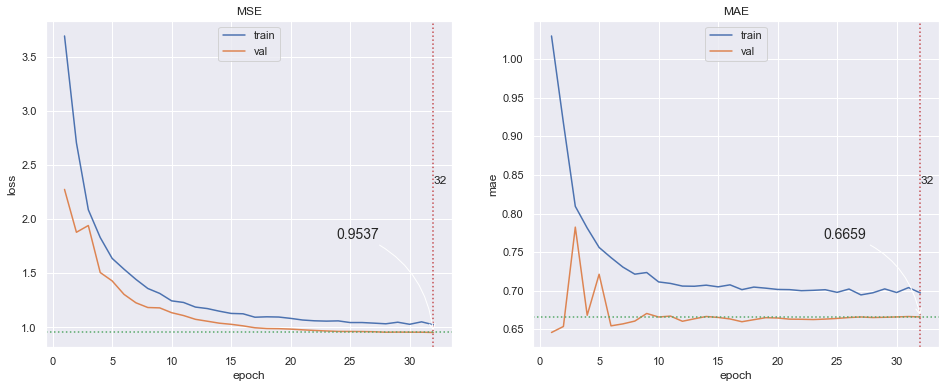

In [35]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

*Судя по всему, просто выходит на модель случайного блуждания*.

In [36]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_regression_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [37]:
pred_log_ret_test = univariate_regression_lstm.predict_generator(test_regr_gen, verbose=1)

10/10 [==============================] - 2s 159ms/step


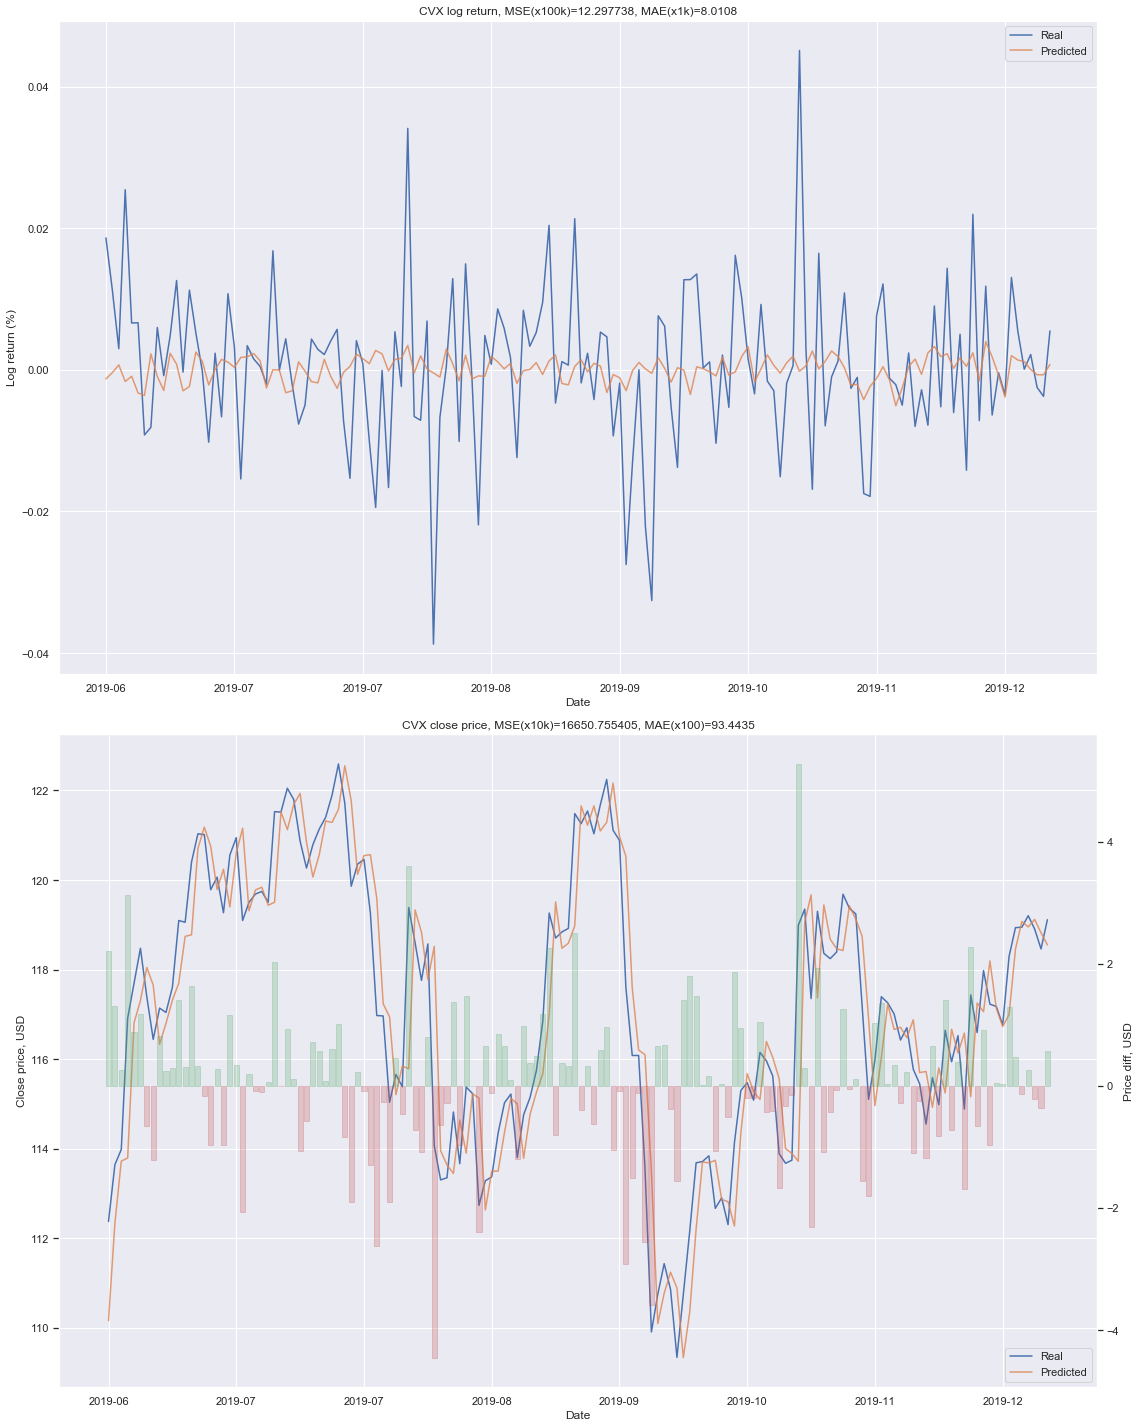

In [38]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 20))

## Задача классификации

Прогнозируем направление изменения цены по сравнению с предыдущим периодом (**0** - снижение, **1** - рост).

In [39]:
model_class_name = 'classification'

In [40]:
train_clf_gen = ClassificationGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_clf_gen = ClassificationGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_clf_gen = ClassificationGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
def build_classification_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    clf = Dense(32)(lstm)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [42]:
univariate_classification_lstm = build_classification_model(test_clf_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [43]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [44]:
univariate_classification_lstm.compile(optimizer=optimizer,
                                         loss={'clf': 'binary_crossentropy'},
                                         metrics={'clf': 'accuracy'})

univariate_classification_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 16)            1152      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                30752     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

#### Дополнительные коллбэки:

In [45]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [46]:
clf_history = utils.train_model(univariate_classification_lstm,
                                model_save_dir, train_clf_gen, val_clf_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
153/154 [============================>.] - ETA: 0s - loss: 2.3924 - accuracy: 0.5012
Epoch 00001: val_loss improved from inf to 1.75546, saving model to models\lstm1_univar\classification\01.hdf5
154/154 [==============================] - 47s 306ms/step - loss: 2.3901 - accuracy: 0.5016 - val_loss: 1.7555 - val_accuracy: 0.4712

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
153/154 [============================>.] - ETA: 0s - loss: 1.5507 - accuracy: 0.5098
Epoch 00002: val_loss improved from 1.75546 to 1.28222, saving model to models\lstm1_univar\classification\02.hdf5
154/154 [==============================] - 41s 265ms/step - loss: 1.5492 - accuracy: 0.5098 - val_loss: 1.2822 - val_accuracy: 0.4808

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
153/154 [============================>.] - ETA: 

153/154 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5584
Epoch 00020: val_loss improved from 0.70816 to 0.70699, saving model to models\lstm1_univar\classification\20.hdf5
154/154 [==============================] - 40s 261ms/step - loss: 0.6932 - accuracy: 0.5575 - val_loss: 0.7070 - val_accuracy: 0.5000

Epoch 00021: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 21/32
153/154 [============================>.] - ETA: 0s - loss: 0.6916 - accuracy: 0.5490
Epoch 00021: val_loss improved from 0.70699 to 0.70481, saving model to models\lstm1_univar\classification\21.hdf5
154/154 [==============================] - 40s 259ms/step - loss: 0.6917 - accuracy: 0.5497 - val_loss: 0.7048 - val_accuracy: 0.5192

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
153/154 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.5441
Epoch 00022: val_loss improved from 0.70481 to 0.70314,

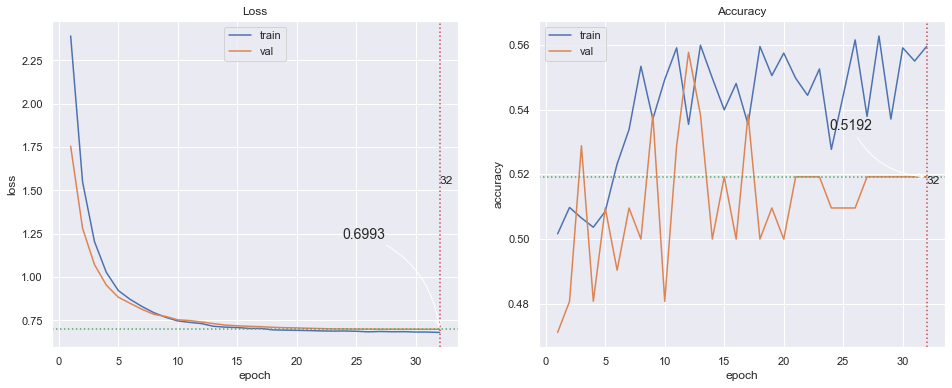

In [47]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

*Разделяющая способность довольно слабая, вероятности обоих классов очень близки к порогу отсечения*.

In [48]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_classification_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [49]:
pred_direction_proba = univariate_classification_lstm.predict_generator(test_clf_gen, verbose=1)

true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

10/10 [==============================] - 1s 134ms/step


0.50274605

In [50]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([71, 77], dtype=int64)),
 (array([0, 1]), array([79, 69], dtype=int64)))

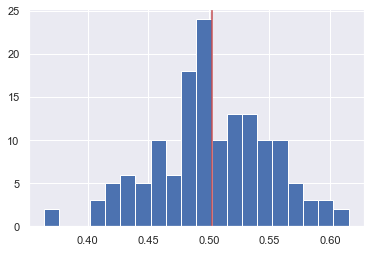

In [51]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [52]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        71
           1       0.64      0.57      0.60        77

    accuracy                           0.61       148
   macro avg       0.61      0.61      0.61       148
weighted avg       0.61      0.61      0.61       148



In [53]:
confusion_matrix(true_direction, predicted_direction)

array([[46, 25],
       [33, 44]], dtype=int64)

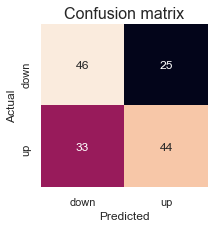

array([[0.58227848, 0.36231884],
       [0.41772152, 0.63768116]])

In [54]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

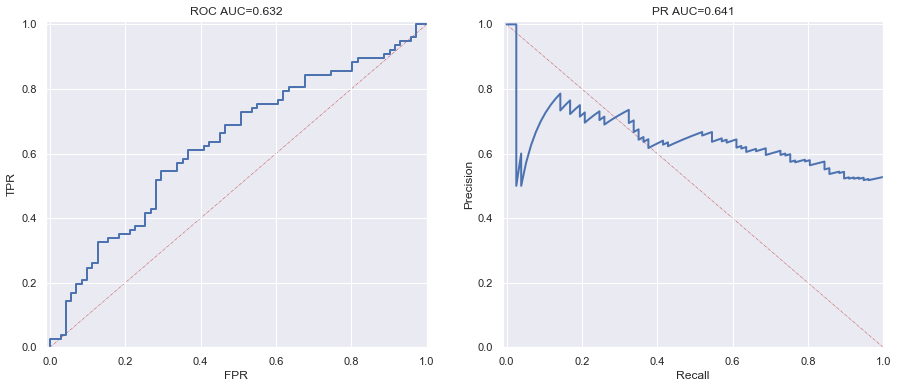

In [55]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

Пытаемся одновременно предсказать и значение цены, и направление изменения, предполагая, что комбинированная ошибка позволит точнее скорректировать веса рекуррентных слоёв.

In [56]:
model_class_name = 'multitask'

In [57]:
train_multi_gen = MultitaskGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_multi_gen = MultitaskGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_multi_gen = MultitaskGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [58]:
def build_multitask_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    # первый выход: задача регрссии
    regr = Dense(32)(lstm)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(32)(lstm)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [59]:
univariate_multitask_lstm = build_multitask_model(train_multi_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [60]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [61]:
univariate_multitask_lstm.compile(optimizer=optimizer,
                                  loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                  loss_weights={'regr': 2., 'clf': 1.},
                                  metrics={'regr': 'mae', 'clf' : 'accuracy'})

univariate_multitask_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 60, 16)       1152        input[0][0]                      
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 960)          0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           30752       flatten_2[0][0]                  
____________________________________________________________________________________________

#### Дополнительные коллбэки:

In [62]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [63]:
multitask_history = utils.train_model(univariate_multitask_lstm,
                                      model_save_dir, train_multi_gen, val_multi_gen,
                                      callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                      force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
153/154 [============================>.] - ETA: 0s - loss: 7.3104 - regr_loss: 2.2404 - clf_loss: 0.8318 - regr_mae: 1.1464 - clf_accuracy: 0.5049
Epoch 00001: val_loss improved from inf to 5.75127, saving model to models\lstm1_univar\multitask\01.hdf5
154/154 [==============================] - 44s 286ms/step - loss: 7.2983 - regr_loss: 2.2354 - clf_loss: 0.8305 - regr_mae: 1.1461 - clf_accuracy: 0.5053 - val_loss: 5.7513 - val_regr_loss: 1.6137 - val_clf_loss: 0.6987 - val_regr_mae: 1.0122 - val_clf_accuracy: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
153/154 [============================>.] - ETA: 0s - loss: 5.5795 - regr_loss: 1.5734 - clf_loss: 0.7628 - regr_mae: 0.9651 - clf_accuracy: 0.5147
Epoch 00002: val_loss improved from 5.75127 to 4.09892, saving model to models\lstm1_univar\multitask\02.hdf5
154/154 [===================

153/154 [============================>.] - ETA: 0s - loss: 3.1324 - regr_loss: 0.9208 - clf_loss: 0.6964 - regr_mae: 0.7056 - clf_accuracy: 0.5286
Epoch 00014: val_loss improved from 2.86146 to 2.83120, saving model to models\lstm1_univar\multitask\14.hdf5
154/154 [==============================] - 47s 303ms/step - loss: 3.1247 - regr_loss: 0.9165 - clf_loss: 0.6973 - regr_mae: 0.7050 - clf_accuracy: 0.5277 - val_loss: 2.8312 - val_regr_loss: 0.7749 - val_clf_loss: 0.7012 - val_regr_mae: 0.6443 - val_clf_accuracy: 0.4712

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
Epoch 15/32
153/154 [============================>.] - ETA: 0s - loss: 3.1171 - regr_loss: 0.9271 - clf_loss: 0.6900 - regr_mae: 0.7117 - clf_accuracy: 0.5368
Epoch 00015: val_loss improved from 2.83120 to 2.81053, saving model to models\lstm1_univar\multitask\15.hdf5
154/154 [==============================] - 50s 323ms/step - loss: 3.1452 - regr_loss: 0.9412 - clf_loss: 0.6900 - regr_


Epoch 00028: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
Epoch 28/32
153/154 [============================>.] - ETA: 0s - loss: 2.9502 - regr_loss: 0.9063 - clf_loss: 0.6885 - regr_mae: 0.7013 - clf_accuracy: 0.5376
Epoch 00028: val_loss improved from 2.71242 to 2.70400, saving model to models\lstm1_univar\multitask\28.hdf5
154/154 [==============================] - 53s 345ms/step - loss: 2.9518 - regr_loss: 0.9070 - clf_loss: 0.6887 - regr_mae: 0.7015 - clf_accuracy: 0.5375 - val_loss: 2.7040 - val_regr_loss: 0.7784 - val_clf_loss: 0.7003 - val_regr_mae: 0.6432 - val_clf_accuracy: 0.4808

Epoch 00029: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
Epoch 29/32
153/154 [============================>.] - ETA: 0s - loss: 2.9206 - regr_loss: 0.8960 - clf_loss: 0.6838 - regr_mae: 0.6964 - clf_accuracy: 0.5519
Epoch 00029: val_loss did not improve from 2.70400
154/154 [==============================] - 46s 297ms/step - loss: 2.9408 - regr_l

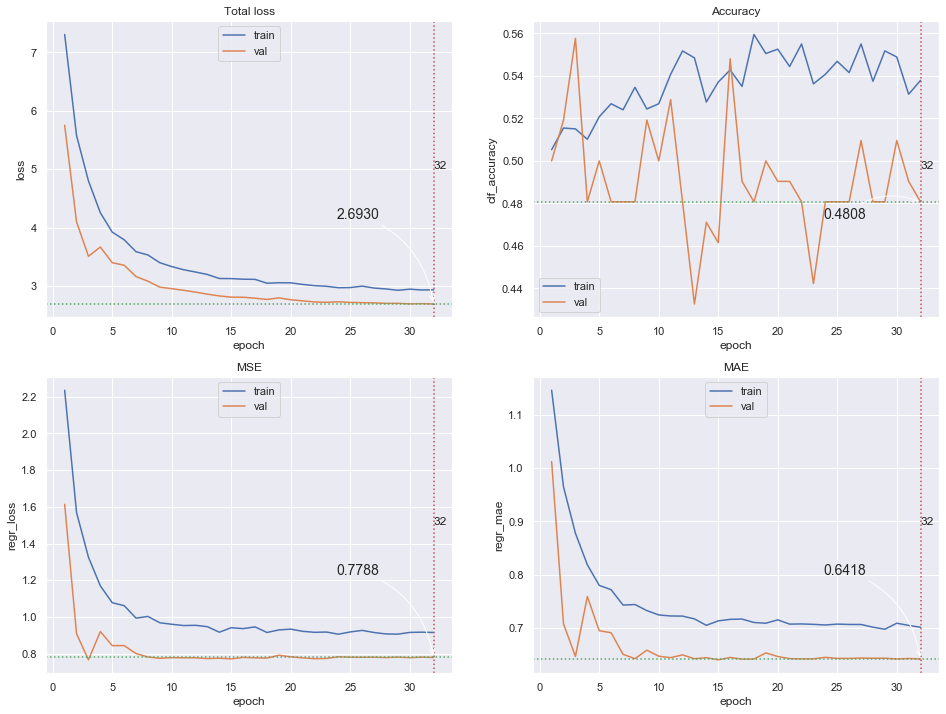

In [64]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plotHelpers.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    plotHelpers.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    plotHelpers.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [65]:
# загружаем последнюю эпоху с минимальным лоссом
univariate_multitask_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [66]:
pred_log_ret, pred_direction_proba = univariate_multitask_lstm.predict_generator(test_multi_gen, verbose=1)

10/10 [==============================] - 2s 151ms/step


In [67]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

array([[ 0.142,  0.511],
       [-0.12 ,  0.484],
       [-0.241,  0.4  ],
       [ 0.086,  0.509],
       [ 0.097,  0.504],
       [ 0.119,  0.544],
       [ 0.048,  0.546],
       [-0.086,  0.479],
       [-0.015,  0.451],
       [ 0.048,  0.475]], dtype=float32)

#### Прогноз задачи регрессии

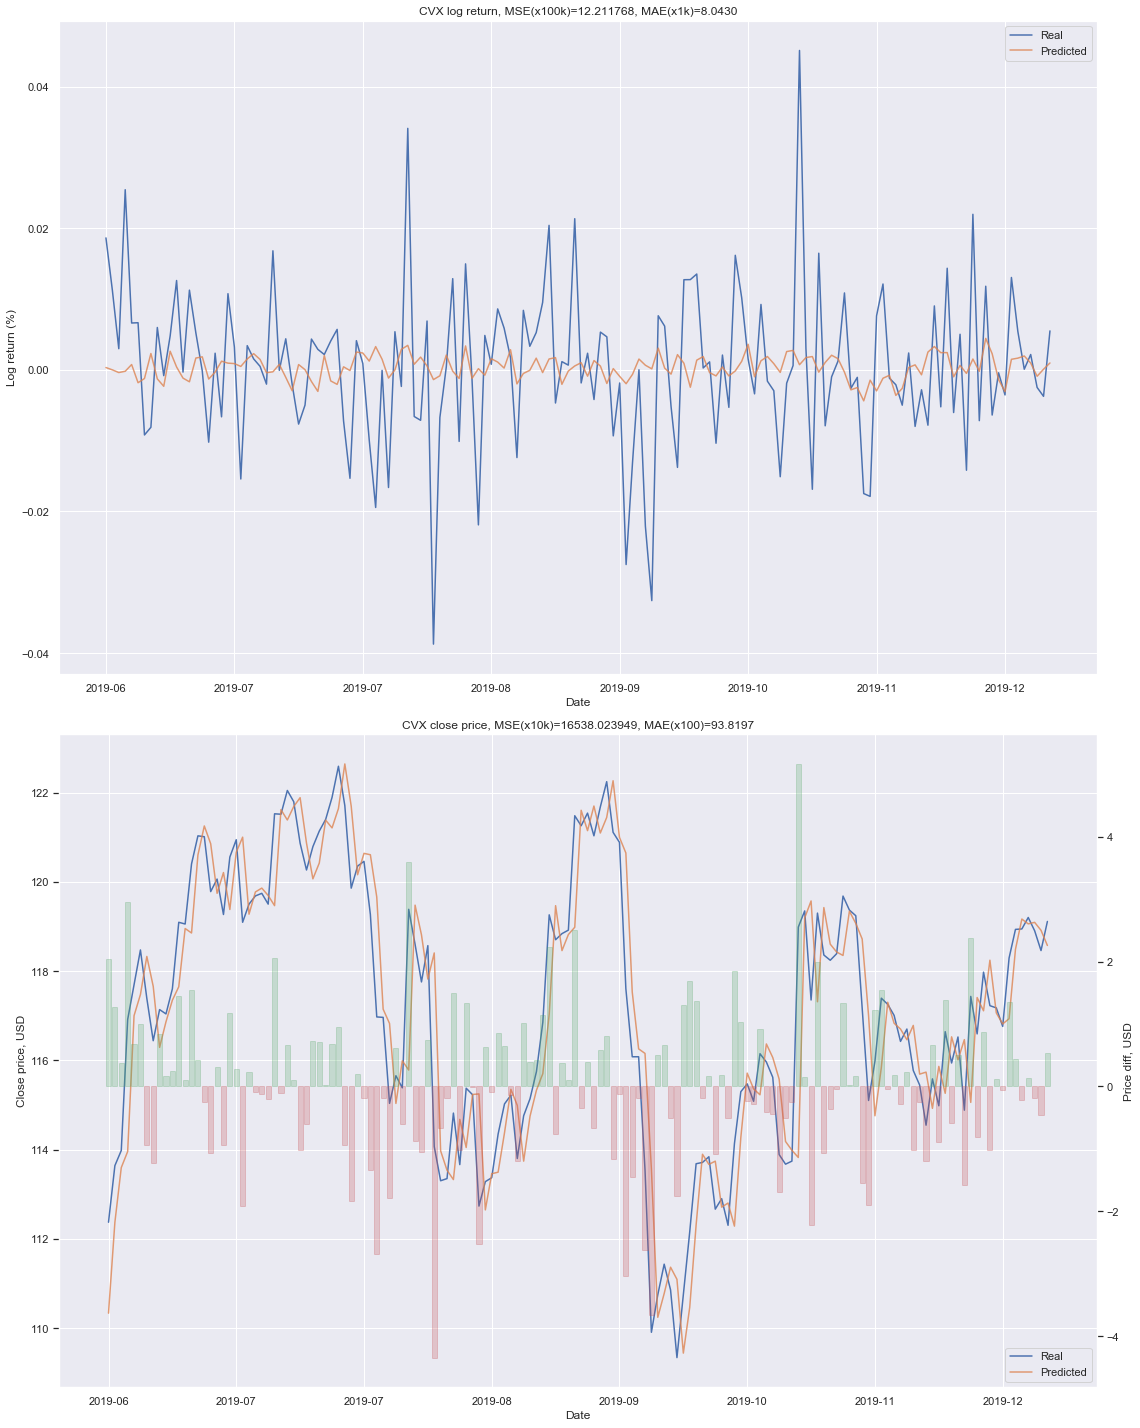

In [68]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret, figsize=(16, 20))

#### Прогноз задачи классификации

*Разделяющая способность по-прежнему слабая*.

In [69]:
true_direction = test_multi_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

0.5066694

In [70]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([71, 77], dtype=int64)),
 (array([0, 1]), array([72, 76], dtype=int64)))

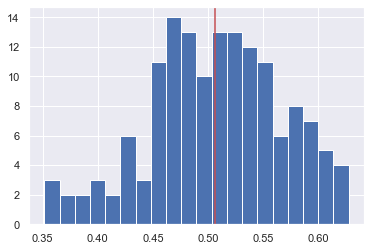

In [71]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [72]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57        71
           1       0.61      0.60      0.60        77

    accuracy                           0.59       148
   macro avg       0.59      0.59      0.59       148
weighted avg       0.59      0.59      0.59       148



In [73]:
confusion_matrix(true_direction, predicted_direction)

array([[41, 30],
       [31, 46]], dtype=int64)

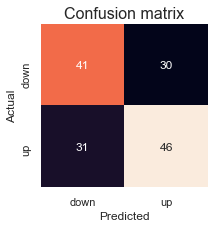

array([[0.569, 0.395],
       [0.431, 0.605]])

In [74]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

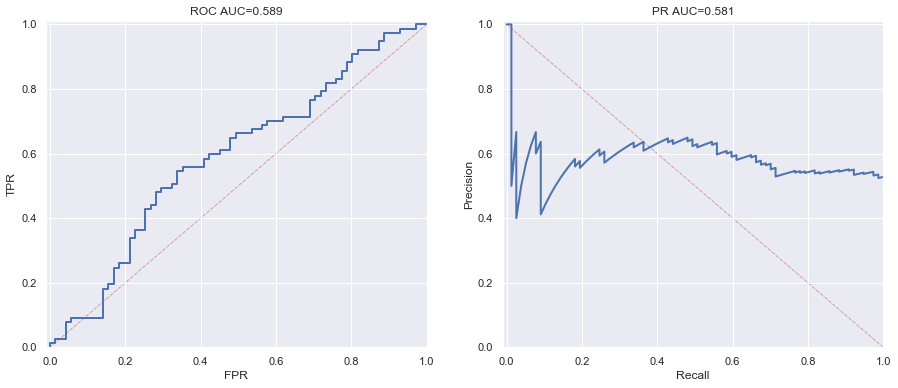

In [75]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# Выводы

1.  Размер батча сильно влияет на скорость обучения.
2.  Инициализация весов (`bias_initializer`) в слое **LSTM** оказалась очень важным параметром.
3.  Модель регрессии пока просто выходит на модель случайного блуждания.
4.  Разделяющая способность модели классификации довольно низкая.
5.  Комбинированная (многозадачная) модель не смогла как-то улучшить качество прогнозирования по сравнению с каждой из двух однозадачных моделей.